In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<Axes: xlabel='Month'>

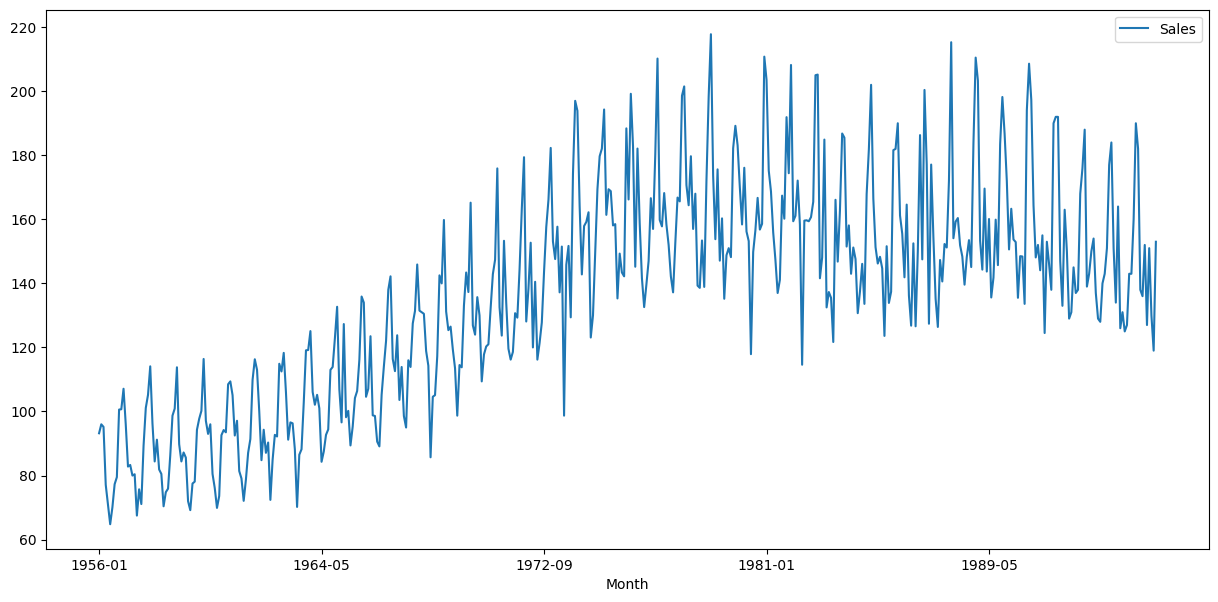

In [3]:
df=pd.read_csv('monthly-beer-production-in-austr.csv')
df.head()

# Updating the header
df.columns=["Month","Sales"]
df.head()
df.describe()
df.set_index('Month',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

Using Adfuller

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
test_result = adfuller(df['Sales'])

In [6]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Stat', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")
    
adfuller_test(df['Sales'])

ADF Test Stat : -2.282661418787573
p-value : 0.17762099829132627
#Lags Used : 17
Number of Observations : 458
weak evidence against null hypothesis, indicating it is non-stationary 


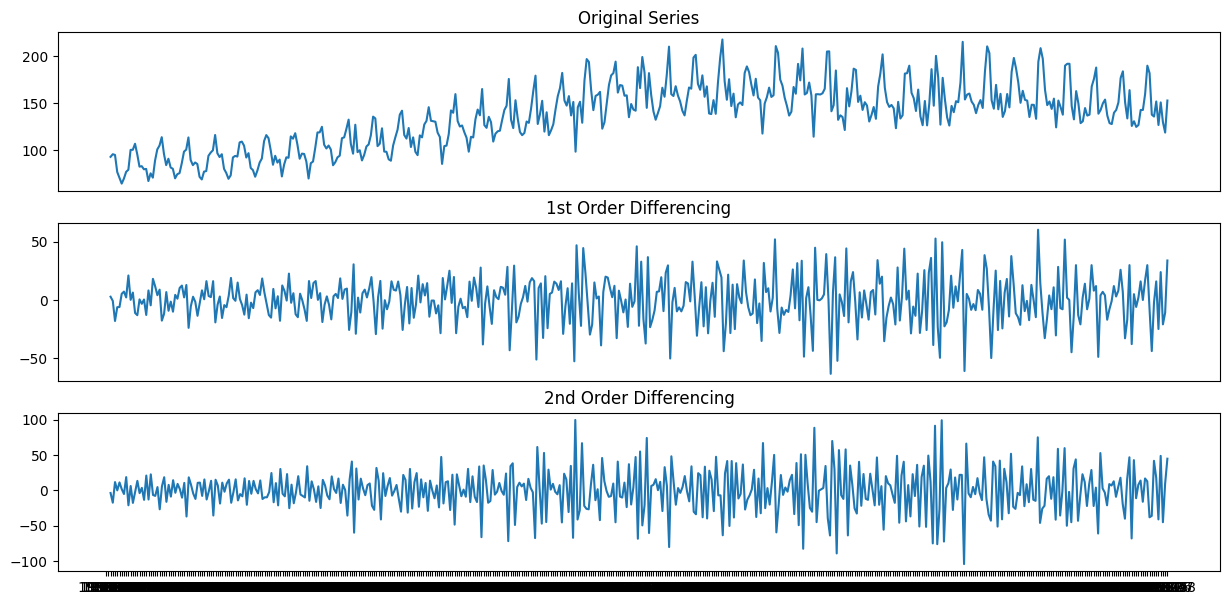

In [7]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df['Sales']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['Sales'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df['Sales'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

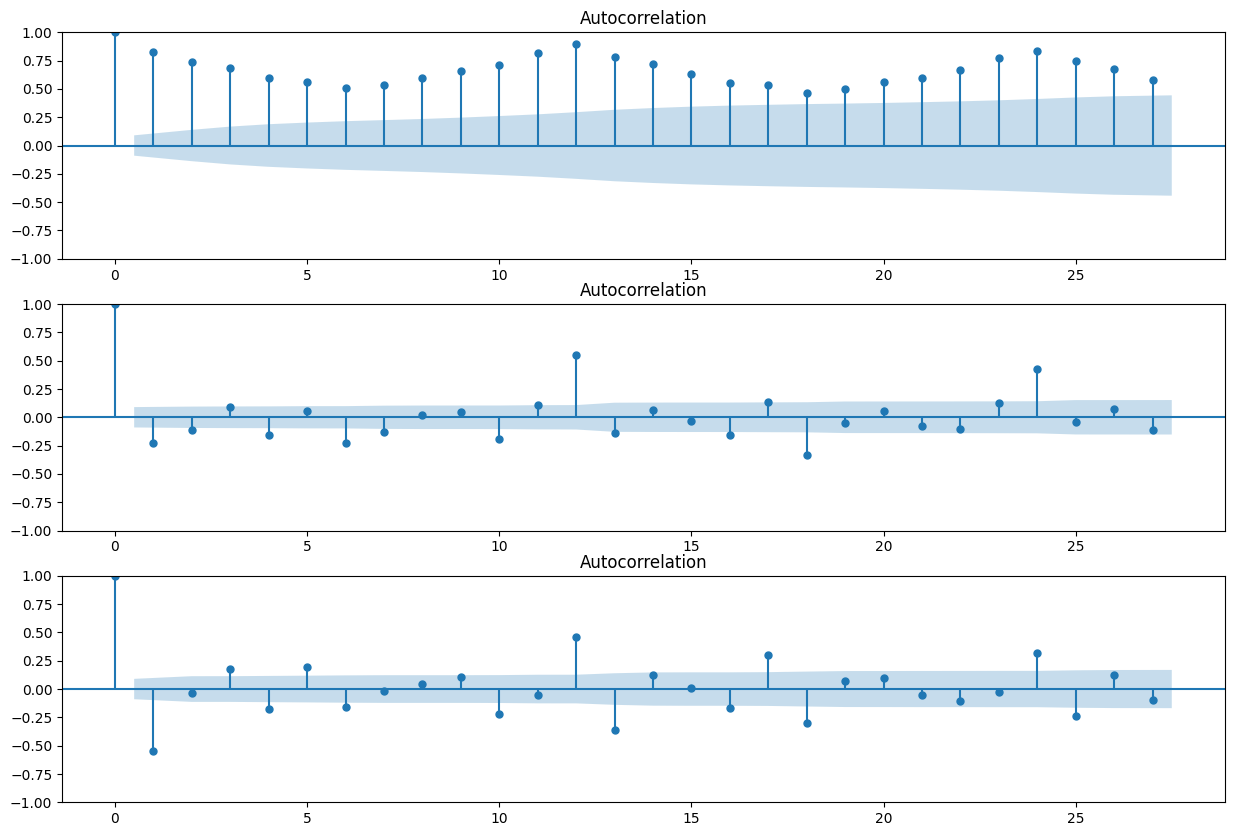

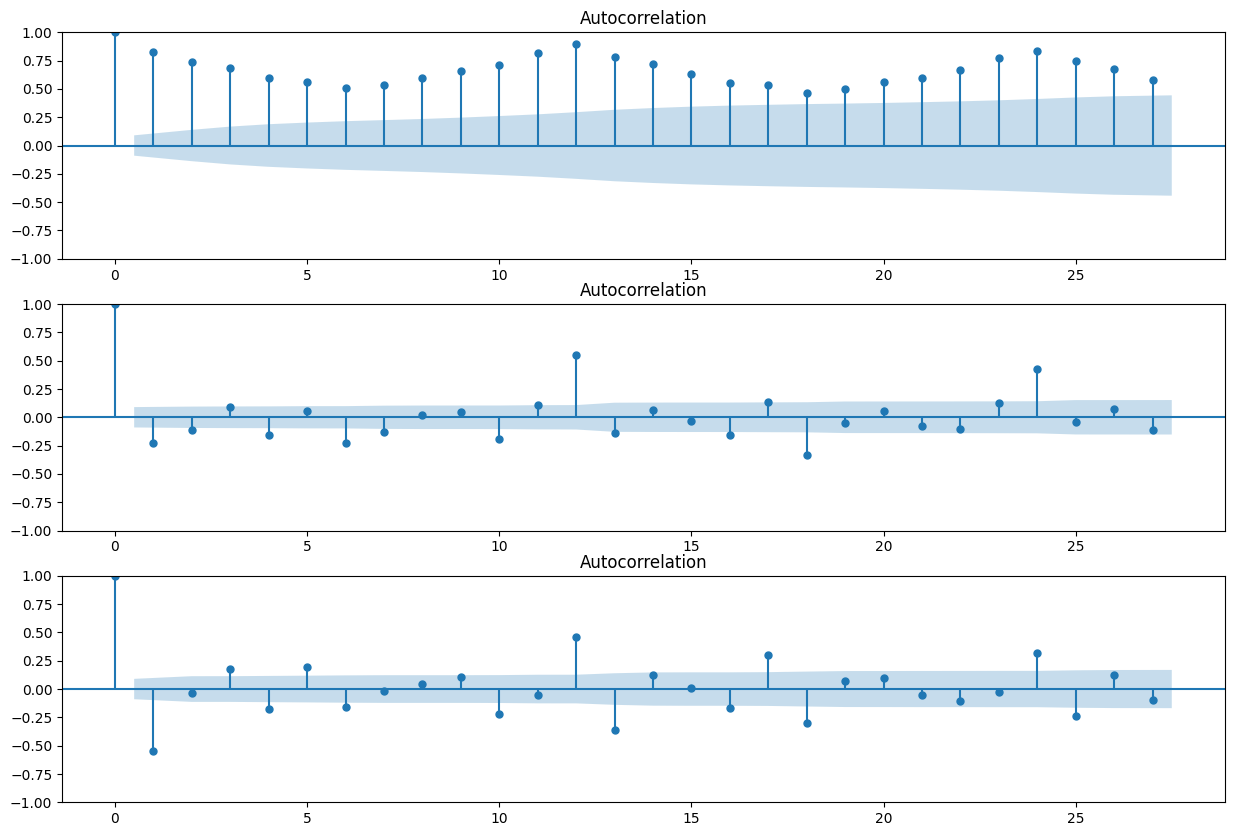

In [8]:
rcParams.update({'figure.figsize': (15,10)})

from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df['Sales'], ax=ax1)
plot_acf(df['Sales'].diff().dropna(), ax=ax2)
plot_acf(df['Sales'].diff().diff().dropna(), ax=ax3)

In [9]:
# Again testing if data is stationary
adfuller_test(df['Sales'].diff().dropna())

ADF Test Stat : -4.980663743064783
p-value : 2.423411785996173e-05
#Lags Used : 18
Number of Observations : 456
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


Creating Auto-correlation

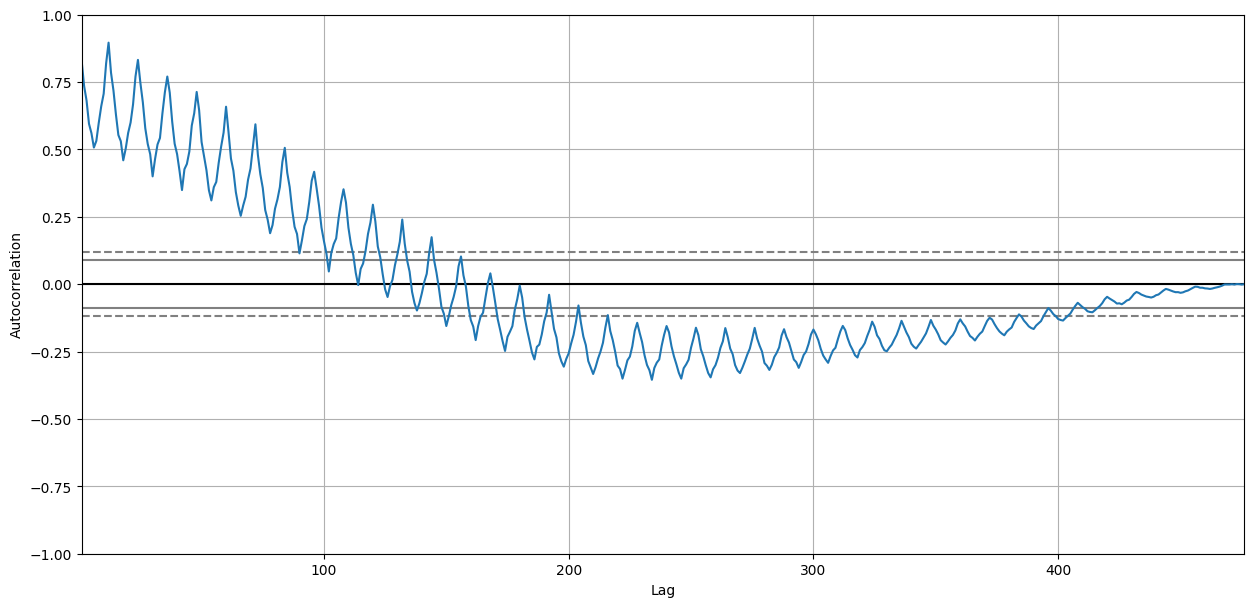

In [10]:
rcParams.update({'figure.figsize': (15,7)})

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

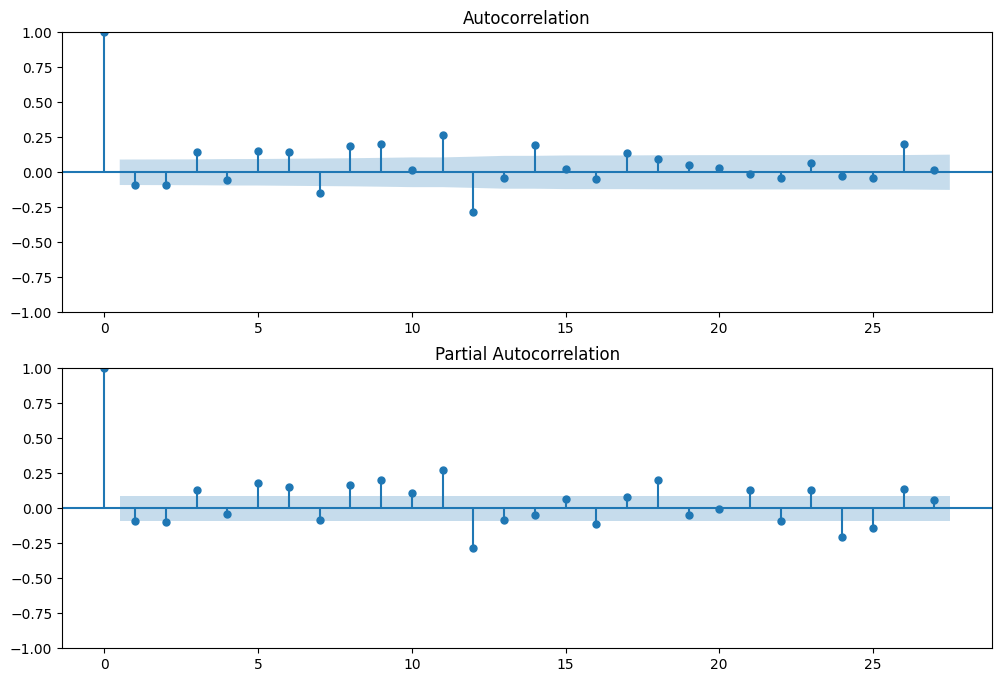

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((df['Sales']-df['Sales'].shift(12)).dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((df['Sales']-df['Sales'].shift(12)).dropna(),ax=ax2)

In [12]:
# For non-seasonal data
# p=1 -> Using PACF
# d=1 -> Using ACF
# q=1  -> Using ACF

from statsmodels.tsa.arima.model import ARIMA
sales_array = df['Sales'].values
model=ARIMA(sales_array ,order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  476
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2029.186
Date:                Fri, 17 Nov 2023   AIC                           4064.372
Time:                        09:47:09   BIC                           4076.862
Sample:                             0   HQIC                          4069.284
                                - 476                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4806      0.044     10.808      0.000       0.393       0.568
ma.L1         -0.9481      0.018    -52.232      0.000      -0.984      -0.912
sigma2       299.8396     18.615     16.107      0.000     263.354     336.325
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.77   Prob(JB):                         0.12
Heteroskedasticity (H):               2.98   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

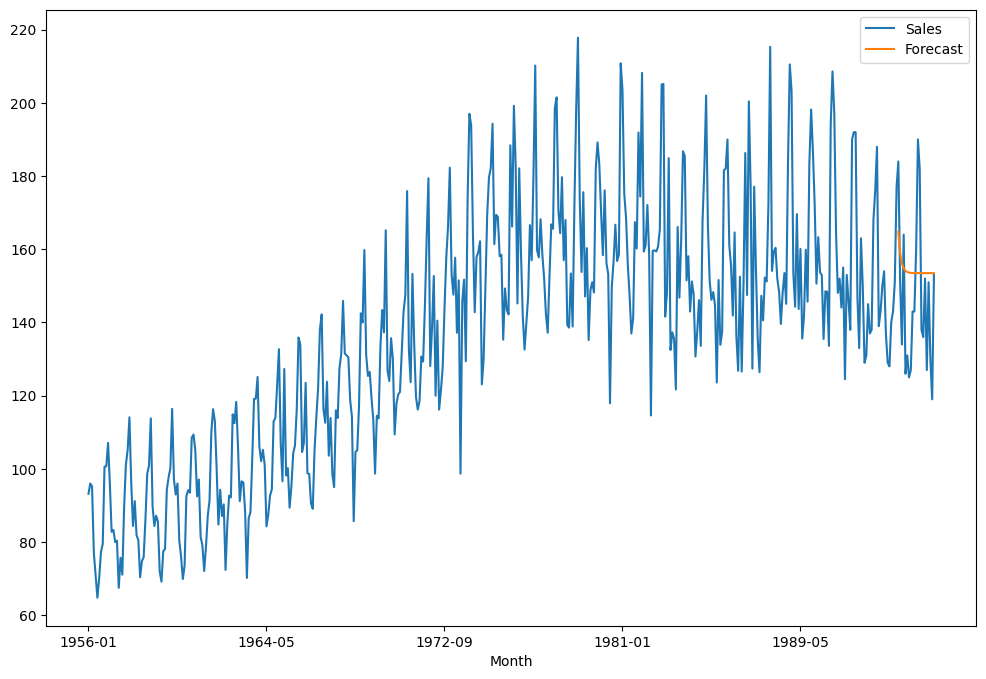

In [13]:
forecast_values = model_fit.predict(start=455, end=475, dynamic=True)

# Create a new DataFrame for the forecast with the correct index
forecast_df = pd.DataFrame(forecast_values, index=df.index[455:476], columns=['Forecast'])

# Merge the forecast DataFrame with the original DataFrame
df = pd.concat([df, forecast_df], axis=1)

# Plot the Sales and forecast columns
df[['Sales', 'Forecast']].plot(figsize=(12, 8))

C:\Users\kaush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kaush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

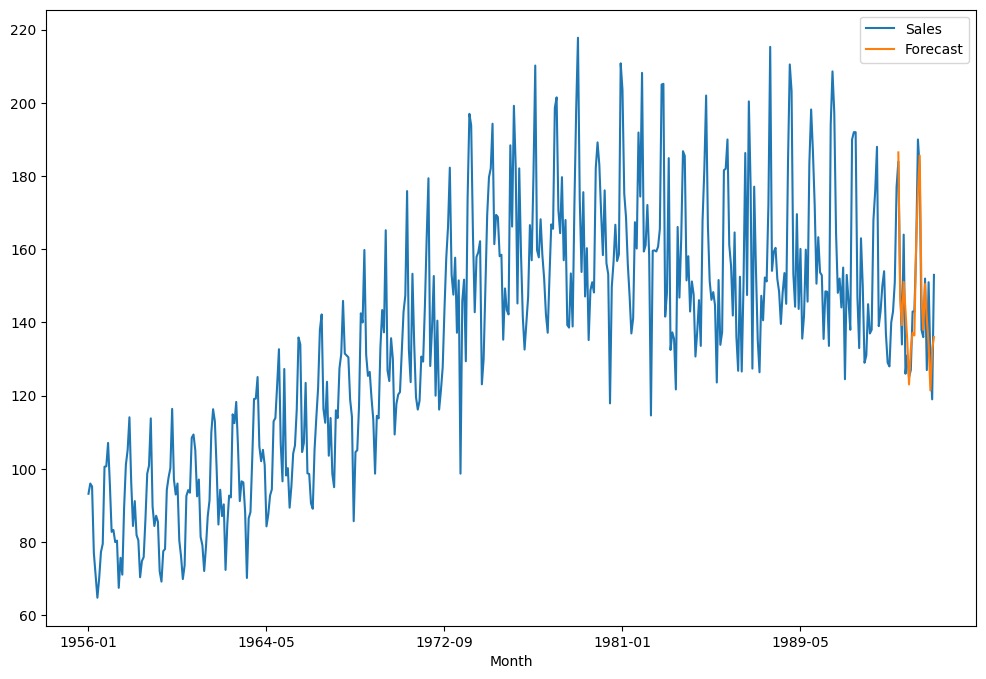

In [14]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['Forecast']=results.predict(start=455,end=475,dynamic=True)
df[['Sales','Forecast']].plot(figsize=(12,8))

<Axes: >

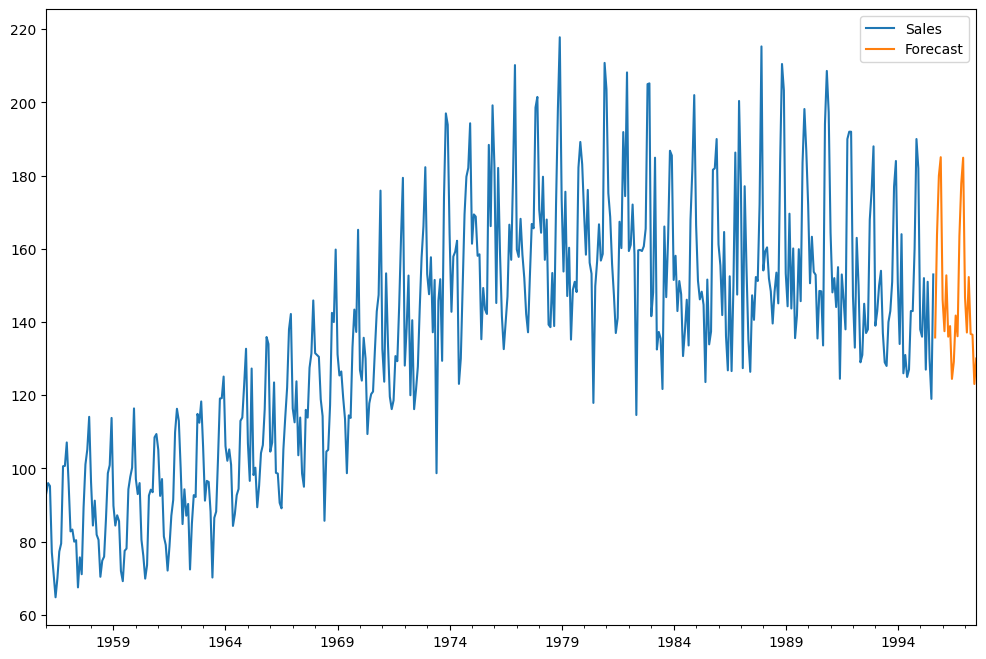

In [15]:
from pandas.tseries.offsets import DateOffset
df.index = pd.to_datetime(df.index)
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Forecast'] = results.predict(start = 476, end = 500, dynamic= True)
future_df[['Sales', 'Forecast']].plot(figsize=(12, 8))